## Installation

In [ ]:
%%capture

# for speechbrain
!pip install -qq torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0 torchtext==0.12.0
!pip install -qq speechbrain==0.5.12

# pyannote.audio
!pip install -qq pyannote.audio

# for visualization purposes
!pip install -qq ipython==7.34.0
!pip install noisereduce
!pip install deepfilternet


In [ ]:
import torch
import numpy as np
import moviepy.editor
import subprocess
import librosa
from pyannote.audio import Pipeline
from pyannote.audio import Audio
from pyannote.core import Segment
from pyannote.audio.pipelines.speaker_verification import PretrainedSpeakerEmbedding


In [ ]:

def to_wav(path):
  if path[-3:] != 'wav':
    new_path= path.split('/')[-1][:-4]+'.wav'
    subprocess.call(['ffmpeg', '-i', path, new_path, '-y'])
    path = new_path
  return path

In [ ]:

model = PretrainedSpeakerEmbedding(
    "speechbrain/spkrec-ecapa-voxceleb",
    device=torch.device("cuda"))

audio = Audio(sample_rate=16000, mono=True)

pipeline = Pipeline.from_pretrained('pyannote/speaker-diarization', use_auth_token="")

In [ ]:

def extract_audio_from_mp4(path):
  new_path = path[:-4]+'.wav'
  try:
    # Replace the parameter with the location of the video
    video = moviepy.editor.VideoFileClip(path)
    audio = video.audio
    # Replace the parameter with the location along with filename
    audio.write_audiofile(new_path)
    return new_path
  except:
    command = "ffmpeg -i {} -ab 160k -ac 2 -ar 44100 -vn {}".format(video_path, new_path)
    subprocess.call(command, shell=True)
  return new_path

In [ ]:
def denoising(path):
  new_path= path[:-4]+"_DeepFilterNet2"+path[-4:]
  command = "deepFilter {}".format(path, new_path)
  subprocess.call(command, shell=True)
  return new_path

In [ ]:

# video_path = "/content/demo_new.mp4"

# command = "ffmpeg -i {} -ab 160k -ac 2 -ar 44100 -vn output_tamil.wav".format(video_path)
# subprocess.call(command, shell=True)
# # path= "/content/output_tamil.wav"

In [ ]:
# path= extract_audio_from_mp4(video_path)
# path= denoising(to_wav(path))
# diarization = pipeline("/content/demo_new_DeepFilterNet2.wav")

In [ ]:
refrences = [["advai", "/content/advai.ogg"], ["dhruv", "/content/dhruv.ogg"]]

In [ ]:
def generate_embedding(start_time, end_time, audio_file_path):
    if audio_file_path != 'wav':
        path = audio_file_path
        audio_file_path = audio_file_path[:-4]+'.wav'
        subprocess.call(['ffmpeg', '-i', path, audio_file_path, '-y'])
    speaker = Segment(start_time, end_time)
    waveform, sample_rate = audio.crop(audio_file_path, speaker)
    return  model(waveform[None])

In [ ]:
def find_refrence_embeddings(refrences):
  refrence_embeddings = []
  for i in range(len(refrences)):
    
    refrence_embeddings.append(generate_embedding(0, 2, refrences[i][1]))
  return refrence_embeddings

In [ ]:
refrence_embeddings = find_refrence_embeddings(refrences)
refrence_embeddings = np.vstack(refrence_embeddings)

In [ ]:
def merge_intervals(data, length):
  merged_intervals = []
  for interval in data:
      is_contained = False
      for other_interval in data:
          if interval != other_interval and other_interval[0] <= interval[0] and other_interval[1] >= interval[1]:
              is_contained = True
              break
      if not is_contained:
          merged_intervals.append(interval)
  merged_intervals= sorted(merged_intervals, key=lambda x: x[0])
  for i in range(len(merged_intervals)-1):
    merged_intervals[i][1] = merged_intervals[i+1][0]

  merged_intervals[-1][1] = length
  merged_intervals[0][0] = 0.

  return merged_intervals

In [ ]:
from scipy.spatial.distance import cdist
def find_similarity(diarization, audio_file):
    transcript = []
    for turn, _, speaker in diarization.itertracks(yield_label=True):
      
      spk_embedding = generate_embedding(turn.start, turn.end, audio_file)
      # print(spk_embedding.shape)
      distances = cdist(spk_embedding, refrence_embeddings, metric='cosine')
      # Find the index of the reference embedding with the smallest distance
      min_dist_idx = refrences[np.argmin(distances)][0]
      # print(min_dist_idx)
      # print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{min_dist_idx}")
      transcript.append([turn.start, turn.end, min_dist_idx])
      
    length = librosa.get_duration(filename = audio_file)
    transcript = merge_intervals(transcript, length)

    with open('transcript.txt', 'w') as f:
        for row in transcript:
          f.write(' '.join(map(str, row)) + '\n')
    return transcript
  

In [ ]:
video_path = "/content/demo_2_1.mp4"
path= extract_audio_from_mp4(video_path)
diarization = pipeline(path)

MoviePy - Writing audio in /content/demo_2_1.wav


MoviePy - Done.


In [ ]:
diarization = pipeline(to_wav("/content/demo_2_1.mp3"))

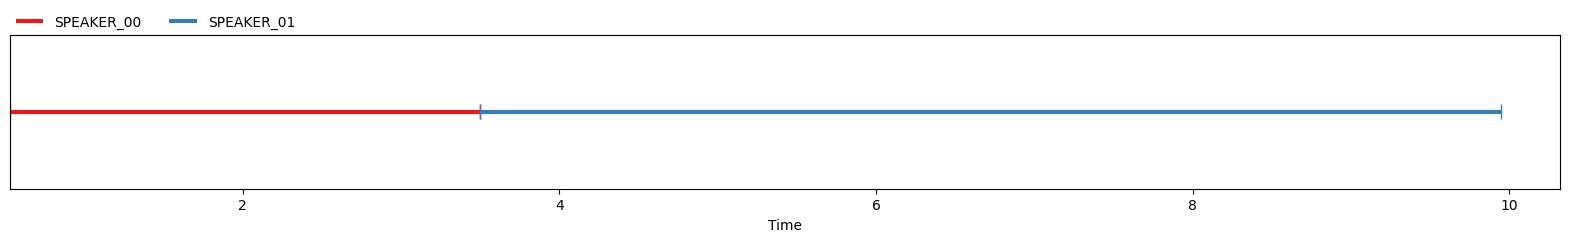

In [ ]:
diarization

In [ ]:
transcript = find_similarity(diarization, path)

In [ ]:
transcript

[[0.0, 3.5015625000000004, 'dhruv'], [3.5015625000000004, 10.26, 'advai']]

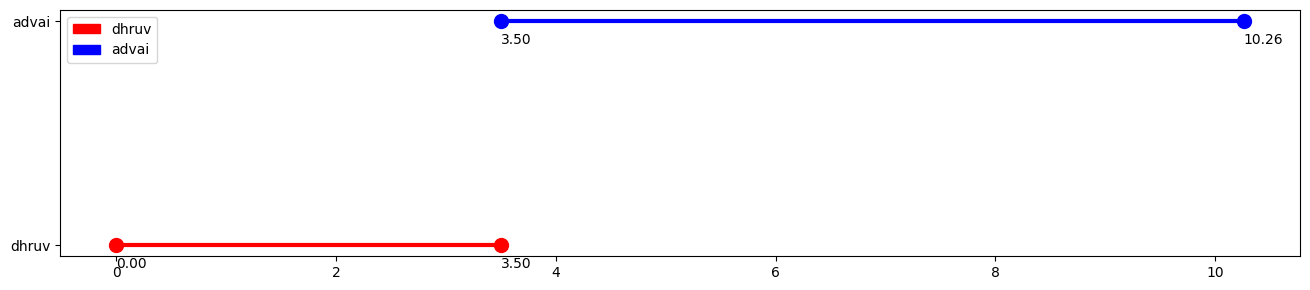

In [ ]:
# Create figure and axis objects
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
intervals= transcript
colors = {'dhruv': 'red', 'advai': 'blue'}

fig, ax = plt.subplots(figsize=plt.figaspect(0.2))

# Create a dictionary to store the y-coordinate for each speaker
levels = {'dhruv': 1, 'advai': 2}

for start, end, label in intervals:
    # Use the levels dictionary to determine the y-coordinate for the current interval
    y = levels[label]
    # Plot a horizontal line for the interval, with the y-coordinate determined by the speaker
    ax.plot([start, end], [y, y], linewidth=3, color=colors[label], marker='o', markersize=10)
    # Add text labels at the start and end of the line
    ax.text(start, y-0.1, f"{start:.2f}", fontsize=10)
    ax.text(end, y-0.1, f"{end:.2f}", fontsize=10)

# Create legend
handles = [mpatches.Patch(color=color, label=label) for label, color in colors.items()]
plt.legend(handles=handles)

# Set y-ticks and labels
ax.set_yticks([1, 2])
ax.set_yticklabels(['dhruv', 'advai'])

plt.show()

That's it? Yes, that's it :-)

In [ ]:

import subprocess
path = "/content/advai.ogg"
if path[-3:] != 'wav':
  subprocess.call(['ffmpeg', '-i', path, 'advai.wav', '-y'])
  path = 'advai.wav'
# extract embedding for a speaker speaking between t=3s and t=6s
speaker1 = Segment(0., 2.)
waveform1, sample_rate = audio.crop("advai.wav", speaker1)
embedding1 = model(waveform1[None])

# # extract embedding for a speaker speaking between t=7s and t=12s
# speaker2 = Segment(7., 12.)
# waveform2, sample_rate = audio.crop("audio.wav", speaker2)
# embedding2 = model(waveform2[None])

# # compare embeddings using "cosine" distance
# from scipy.spatial.distance import cdist
# distance = cdist(embedding1, embedding2, metric="cosine")


# Evaluation with `pyannote.metrics`

Because groundtruth is available, we can evaluate the quality of the diarization pipeline by computing the [diarization error rate](http://pyannote.github.io/pyannote-metrics/reference.html#diarization).

In [ ]:
from pyannote.metrics.diarization import DiarizationErrorRate
metric = DiarizationErrorRate()
der = metric(groundtruth, diarization)

In [ ]:
print(f'diarization error rate = {100 * der:.1f}%')

diarization error rate = 19.2%


This implementation of diarization error rate is brought to you by [`pyannote.metrics`](http://pyannote.github.io/pyannote-metrics/).

It can also be used to improve visualization by find the optimal one-to-one mapping between groundtruth and hypothesized speakers.

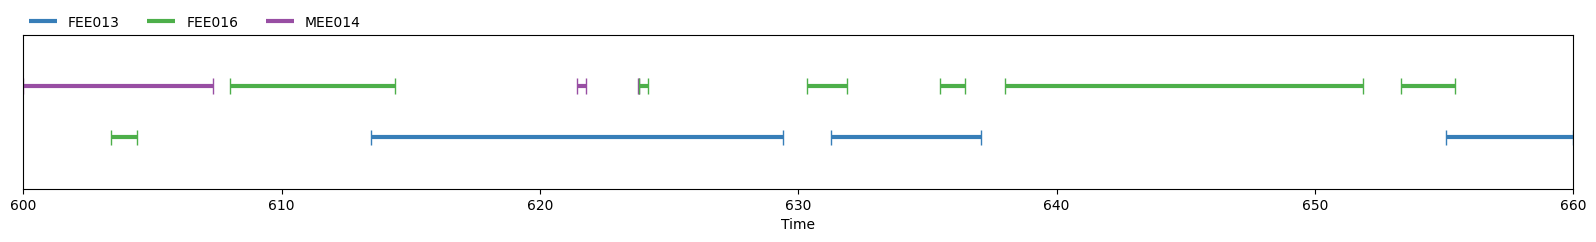

In [ ]:
mapping = metric.optimal_mapping(groundtruth, diarization)
diarization.rename_labels(mapping=mapping)

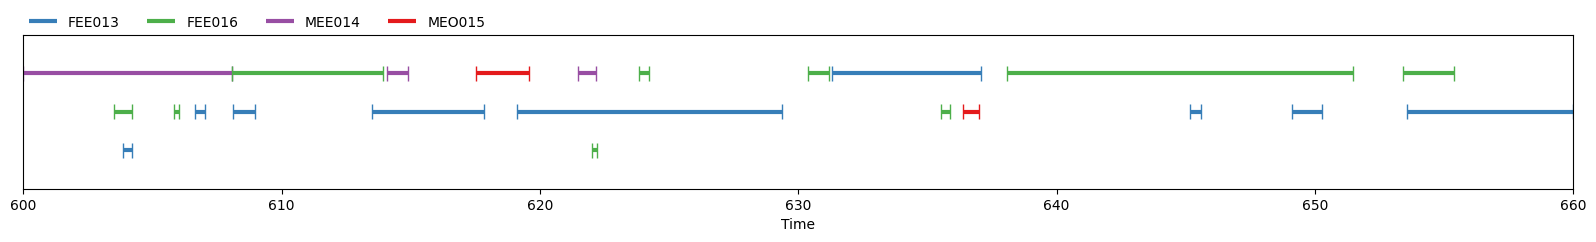

In [ ]:
groundtruth